Tento notebook obsahuje kod v Pytoch, který zpracovává dataset EuroSAT.
Notebook obsahuje 5 částí:
1. Zpracování pomocí konvoluční sítě
2. zpracování pomocí MLP sítě
3. využítí Vision transformeru
4. MLP s random search
5. konvoluční síť s data augmentation

Každá část je označena a obsahuje detailnější popis.

Autor: Marek Havelka

Popis datasetu EuroSAT
Dataset EuroSAT obsahuje 27 000 satelitních snímků(64x64 pixelů) s označenými třídami (10). Tento dataset se dá, stejně jako v případě této práce, využít k trénování modelu pro rozpoznávání typu terénu.

1. část - Konvoluční síť

In [ ]:
from torchvision.datasets import EuroSAT
from torchvision.transforms import v2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        """
        dataset: libovolný PyTorch dataset, který v __getitem__ vrací (image, label),
                 např. torchvision.datasets.EuroSAT
        """
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # EuroSAT (torchvision) vrací tuple (PIL.Image, int label)
        image, label = self.dataset[idx]

        # pro jistotu – kdyby byl někdy grayscale
        if hasattr(image, "mode") and image.mode == "L":
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_class_distribution(self):
        """
        Vrátí (unique_labels, counts) pro celý dataset.
        Očekává, že self.dataset[i] vrací (image, label).
        """
        labels = []
        for i in range(len(self.dataset)):
            _, label = self.dataset[i]
            labels.append(label)

        counts = Counter(labels)
        unique_labels = sorted(counts.keys())
        label_counts = [counts[l] for l in unique_labels]

        return np.array(unique_labels), np.array(label_counts)



In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

base_dataset = datasets.EuroSAT(
    root="data",
    download=True,
    transform=None
)

print(len(base_dataset))      # 27000
print(base_dataset[0][0].size)  # velikost obrázku
print(base_dataset[0][1])       # label 0-9


27000
(64, 64)
0


In [ ]:
from torch.utils.data import random_split
dataset_size = len(base_dataset)  # 27000

train_size = int(0.8 * dataset_size)   # 21600
val_size   = int(0.1 * dataset_size)   # 2700
test_size  = dataset_size - train_size - val_size  # 2700

train_base, val_base, test_base = random_split(
    base_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)   # pro reprodukovatelnost
)

print(len(train_base), len(val_base), len(test_base))


21600 2700 2700


In [ ]:
#vytvoření transofrmeru - v tomto případě bez data augmentation (s data augmentation v 5. části)

In [ ]:
base_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = CustomImageDataset(train_base, transform=base_transform)
val_dataset   = CustomImageDataset(val_base,   transform=base_transform)
test_dataset  = CustomImageDataset(test_base,  transform=base_transform)


In [ ]:
#načtení a zobrazení náhodného prvku z trénovací množiny

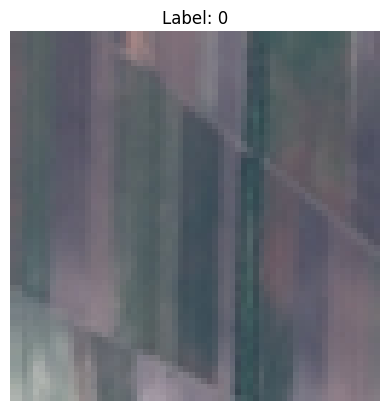

In [ ]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(train_base)-1)
image, label = train_base[idx]

plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


In [ ]:
#dataloadery
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
#definování trénovací funkce

In [ ]:
import torch
import torch.optim as optim
import copy

def train_model(model, criterion, optimizer,
                train_loader, validation_loader,
                epochs, device, patience, min_delta,
                scheduler=None):

    best_val_accuracy = float('-inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for e in range(epochs):
        # ---------- TRAIN ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)          # logits [B, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss_epoch = running_loss / max(1, len(train_loader))
        train_acc_epoch  = correct_train / max(1, total_train)
        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_acc_epoch)

        # ---------- VALIDATION ----------
        model.eval()
        val_loss_sum = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()

                predicted = outputs.argmax(dim=1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        current_val_loss = val_loss_sum / max(1, len(validation_loader))
        current_val_accuracy = correct_val / max(1, total_val)
        val_losses.append(current_val_loss)
        val_accuracies.append(current_val_accuracy)

        # ---------- SCHEDULER ----------
        if scheduler is not None:
            scheduler.step(current_val_loss)

        print(f"Epoch {e+1}/{epochs} | "
              f"Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.4f} | "
              f"Val Loss: {current_val_loss:.4f} | Val Acc: {current_val_accuracy:.4f}")

        # ---------- EARLY STOPPING ----------
        if current_val_accuracy > best_val_accuracy + min_delta:
            best_val_accuracy = current_val_accuracy
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            print("  -> Validation accuracy improved, saving model.")
        else:
            epochs_no_improve += 1
            print(f"  -> No improvement for {epochs_no_improve} epochs.")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {e+1} epochs.")
                break

    if best_model_state is None:
        best_model_state = copy.deepcopy(model.state_dict())
        print("No improvement observed, returning the last model state.")
    else:
        print("Returning model state with the best validation accuracy.")

    return best_model_state, train_losses, val_losses, train_accuracies, val_accuracies


Zde je definována konečná architektura konvoluční sítě. Tato architektura byla zvolena jako úplně první. Jde o architekturu, která byla využita pro dataset cifar10.
Navzdory odlišné povaze datasetů je tato architektrua schopna dosahovat velmi dobrých výsledků pro případady.

Nastavení architektury a řešení přeučení v rámci datasetu cifar10 probíhalo takto(stejná architektura byla použita i zde):

Bylo experimentováno s různými architekturami. U všech předešlých architektur byl problém jak nízká přesnost (do 75% přesnost pro trénovací data), tak přeučení modelu. Jedna z předešlých architektur vypadala následovně:
x = self.conv1(x) - out_channels = 64 x = self.conv2(x) - out_channels = 64 x = self.conv3(x) - out_channels = 64 x = self.pool(x) x = self.relu(x)

x = self.conv4(x) - out_channels = 128 x = self.conv5(x) - out_channels = 256 x = self.conv6(x) - out_channels = 64 x = self.pool(x) x = self.relu(x) x = self.flatten(x) outputs = self.fc(x) return outputs

Po experimentech s nastavením filtrů nebo úpravou jednotlivích vrstev byla pro zlepšení výsledků modelu - tj. zvýšení přesnosti testovací množiny i řešení přeučení upravena architektura do stávající podoby, tedy do 3 bloků. Byl využit BatchNorm pro stabilnější trénink a po testování byla learning rate factor nastavena na 0,4. Těmito kroky byla vyřešena flukturace při trénování modelu. Pro řešení přeučení byl využit dropout po každém bloku a nastaven weight_decay. Také byl nastaven early stopping s patience na 5 (snížen z původních 7 kvůli z důvodu složitější architektury). Stávájí nastavení těchto zmíněných hyperparametrů vyřešilo problém s přeučením. Např. weight_decay byl původně nastaven na vyšší hodnotu, což však vedlo ke snížení výkonnosti modelu.

Původní myšlenkou bylo využít tuto architekturu jako základ a později zlepšovat výkonnost modelu. Již v prvním běhu se však ukázalo, že model dosahuje velmi kvalitních hodnot, viz níže.


Odkaz na zpracování datasetu cifar10 pomocí identické architektury: https://colab.research.google.com/drive/1Tshb3-V7bHUEIgphT8J9vDlKDhzmhL-X?usp=sharing


In [ ]:
import torch
from torch import nn

class ConvNet1(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)   # 32 -> 16
        self.drop1 = nn.Dropout2d(p=0.25)

        # Block 2: 64x16x16 -> 128x8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)   # 16 -> 8
        self.drop2 = nn.Dropout2d(p=0.40)

        # Block 3: 128x8x8 -> 256x4x4
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.bn5   = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1)
        self.bn6   = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)   # 8 -> 4
        self.drop3 = nn.Dropout2d(p=0.40)

        # Hlava
        self.gap   = nn.AdaptiveAvgPool2d(1)  # -> (256, 1, 1)
        self.flatten = nn.Flatten()
        self.fc    = nn.Linear(256, num_classes)
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        # Block 1
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x)
        x = self.conv2(x); x = self.bn2(x); x = self.relu(x)
        x = self.pool1(x); x = self.drop1(x)

        # Block 2
        x = self.conv3(x); x = self.bn3(x); x = self.relu(x)
        x = self.conv4(x); x = self.bn4(x); x = self.relu(x)
        x = self.pool2(x); x = self.drop2(x)

        # Block 3
        x = self.conv5(x); x = self.bn5(x); x = self.relu(x)
        x = self.conv6(x); x = self.bn6(x); x = self.relu(x)
        x = self.pool3(x); x = self.drop3(x)

        # head
        x = self.gap(x)
        x = self.flatten(x)
        logits = self.fc(x)
        return logits


cnn = ConvNet1()
print(cnn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
print(f"Model moved to: {device}")


from torchsummary import summary
print("Model Summary:")
print(summary(cnn, (3, 64, 64), device=str(device)))


ConvNet1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.4, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

V této buňce probíhá trénování výše definovaného modelu.
Ve výpisu je možné sledovat přesnost modelu. V 21 epoše/iteraci model dosahuje přesnosti na validačních datech přes 95 %. (Poté dochází k early stoppingu.)

In [ ]:
# instance modelu
cnn_model = ConvNet1().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # sledujeme validation loss
    factor=0.4,      # snížení LR na 0.4 původní hodnoty
    patience=2       # počká 2 epochy bez zlepšení
)

# Early stopping parameters
patience = 5
min_delta = 0.0
epochs_to_train = 30

print("\n--- Training CNN Model ---")
best_cnn_model_state, cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = \
    train_model(
        model=cnn_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience,
        min_delta=min_delta,
        scheduler=scheduler
    )



--- Training CNN Model ---
Epoch 1/30 | Train Loss: 1.1058 | Train Acc: 0.6024 | Val Loss: 0.7209 | Val Acc: 0.7570
  -> Validation accuracy improved, saving model.
Epoch 2/30 | Train Loss: 0.8050 | Train Acc: 0.7156 | Val Loss: 0.6684 | Val Acc: 0.7648
  -> Validation accuracy improved, saving model.
Epoch 3/30 | Train Loss: 0.6896 | Train Acc: 0.7603 | Val Loss: 0.5834 | Val Acc: 0.7952
  -> Validation accuracy improved, saving model.
Epoch 4/30 | Train Loss: 0.6103 | Train Acc: 0.7902 | Val Loss: 0.4685 | Val Acc: 0.8415
  -> Validation accuracy improved, saving model.
Epoch 5/30 | Train Loss: 0.5705 | Train Acc: 0.8076 | Val Loss: 0.5803 | Val Acc: 0.8126
  -> No improvement for 1 epochs.
Epoch 6/30 | Train Loss: 0.5202 | Train Acc: 0.8212 | Val Loss: 0.4388 | Val Acc: 0.8437
  -> Validation accuracy improved, saving model.
Epoch 7/30 | Train Loss: 0.4866 | Train Acc: 0.8367 | Val Loss: 0.5063 | Val Acc: 0.8430
  -> No improvement for 1 epochs.
Epoch 8/30 | Train Loss: 0.4507 | Tr

In [ ]:
#definice názvů tříd pro potřeby matice záměn
class_names = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]


Níže je možné vidět matici záměn pro konvoluční síť definovanou vyše. Matice prozrazuje že model velmi dobře rozpornává jednotlivé třídy.

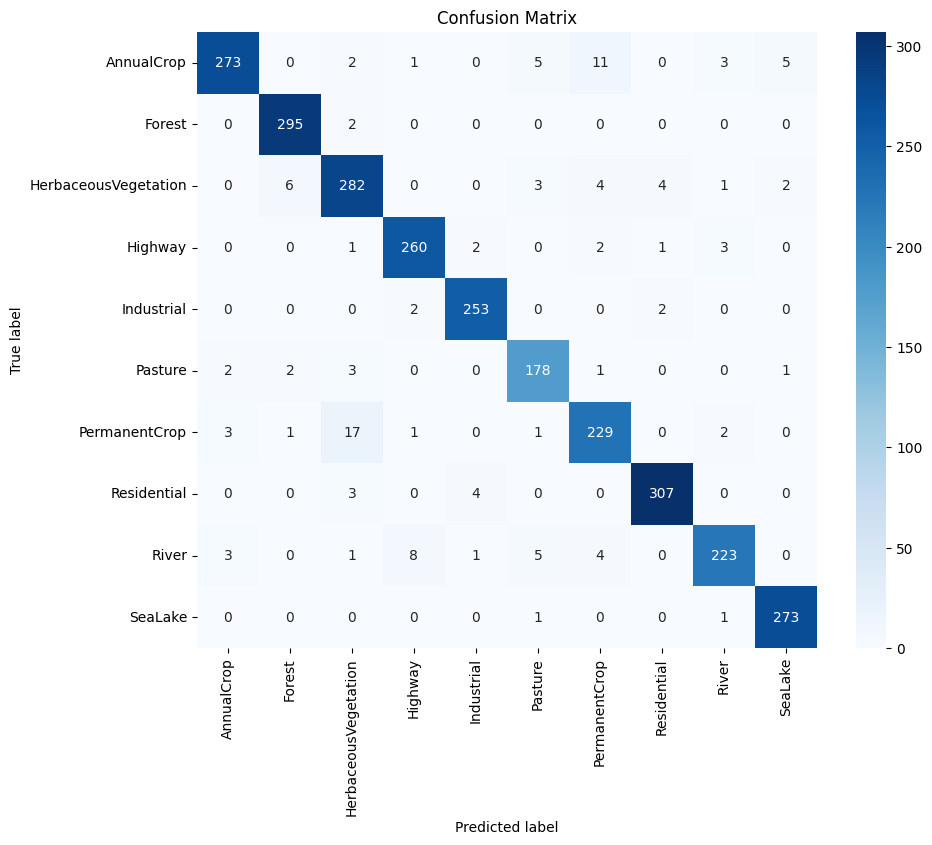

In [ ]:
# 1. Load the best model state
cnn_model.load_state_dict(best_cnn_model_state)
cnn_model.eval() # Set the model to evaluation mode

# 2. Evaluate the model on the test set
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3. Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

# 4. Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name="Model"):

    epochs = range(1, len(train_accuracies) + 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot Accuracy on the first subplot (ax1)
    ax1.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    ax1.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    ax1.set_title(f'{model_name} Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot Loss on the second subplot (ax2)
    ax2.plot(epochs, train_losses, 'bo', label='Training loss')
    ax2.plot(epochs, val_losses, 'b', label='Validation loss')
    ax2.set_title(f'{model_name} Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Adjust subplot parameters for a tight layout
    plt.tight_layout()
    #plt.savefig(f'{model_name.lower().replace(" ", "_")}_training_history.png') # Save the combined plot
    # Display the combined plot in Jupyter Notebook
    plt.show()

Graf zachycující vývoj přesnosti konvoluční sítě během trénování.
V rámci 26 epoch, po které byl model trénován se přesnost na validačních datech zvýšila z cca 75 % na 95 %. Za povšimnutí stojí propad přesnosti v (pravděpodobně) 12 epoše. Nejspíše se jedná o náhodný propad, neboť trénovací přesnost je i v této epoše stabilní. Navíc v další epoše validační přesnost vrací zpět a poté dále roste. Napříč epochami nedochází (kromě zmíněného propadu) k výrazným fluktuacím. Zároveň je patrné, že model je dobře regularizovaný a nedochází k overfittingu.

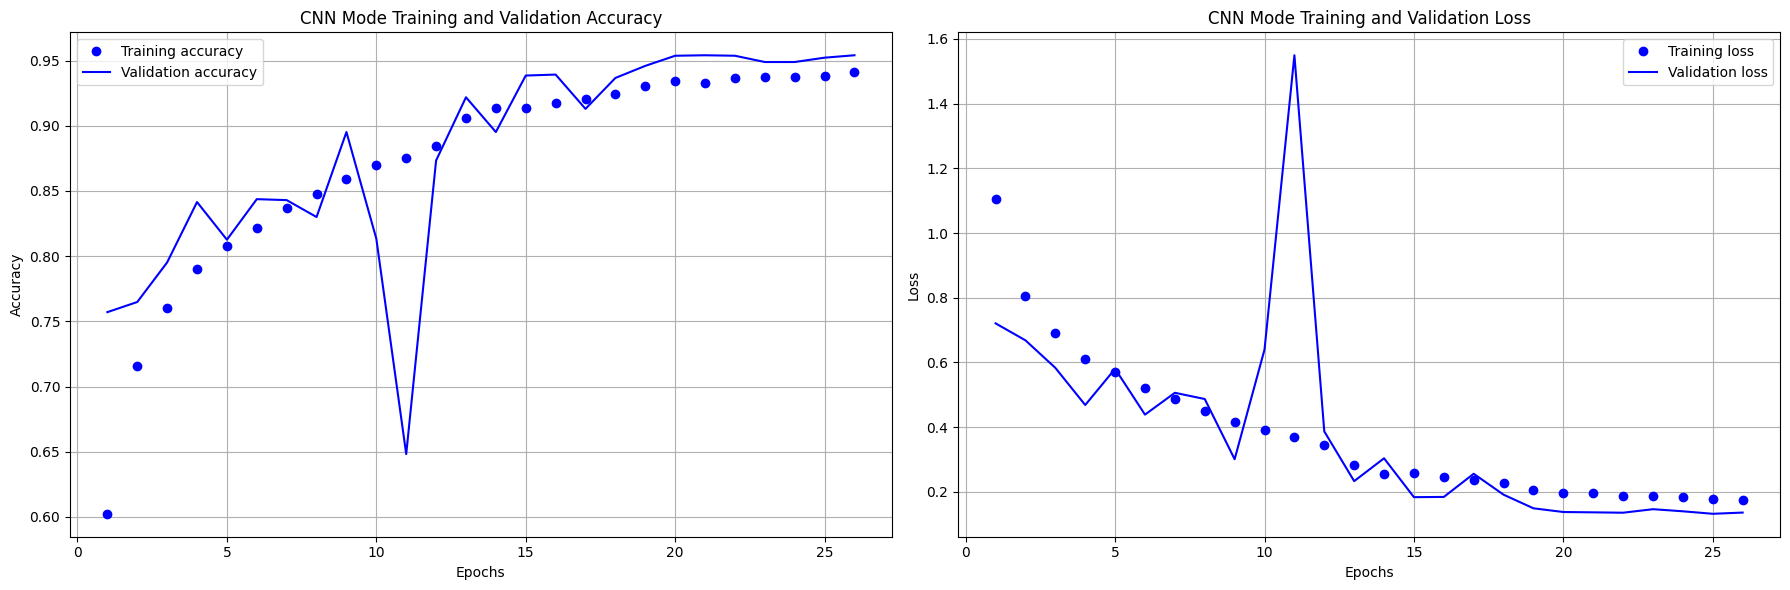

In [ ]:
plot_training_history(cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies, model_name="CNN Mode")

Nahrání a otestování nejlepšího modelu.
Model na testovacích datech dosahuje přes 95% úspěšnosti.

In [ ]:
import torch
from torch import nn

# 1. Narhání nejlepšího modelu
cnn_model.load_state_dict(best_cnn_model_state)
cnn_model.to(device)
cnn_model.eval()

# 2. Vyhodnocení přesnosti na testovacím datasetu
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        predicted = outputs.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 95.30%


Pro zajímavost je zde také vyhodnocení jednoho konkrétního příkladu pomocí nejlepšího modelu.

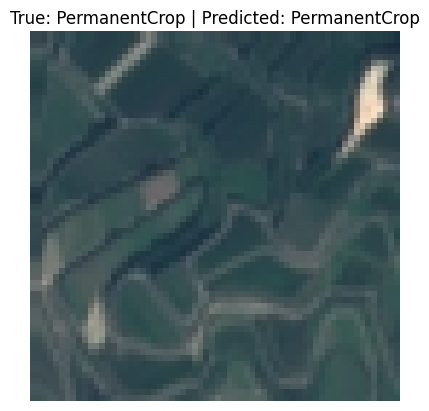

Index: 347
Actual label: PermanentCrop
Predicted label: PermanentCrop


In [ ]:
# Vyhodnocení jednoho konkrétního příkladu
import random
import matplotlib.pyplot as plt

# načtení modelu
cnn_model.load_state_dict(best_cnn_model_state)
cnn_model.to(device)
cnn_model.eval()

# náhodný index v test datasetu
idx = random.randint(0, len(test_dataset)-1)

# vezmeme obrázek i label
image, label = test_dataset[idx]

# přesun vybreného příkladu do device a přidání batch dimenze (1, C, H, W)
image_dev = image.unsqueeze(0).to(device)

# predikce
with torch.no_grad():
    output = cnn_model(image_dev)
    predicted_class = output.argmax(dim=1).item()

# převedení tensoru
img = image.permute(1, 2, 0).cpu().numpy()

# zobrazení obrázeku
plt.imshow(img)
plt.title(f"True: {class_names[label]} | Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

print("Index:", idx)
print("Actual label:", class_names[label])
print("Predicted label:", class_names[predicted_class])


2. část - MLP

Tato část obsahuje 2 MLP architektury pro potřeby porovnání s konvoluční síťí.
První je jednoduchá MLP síť. Druhá archiktura je robustnější. Cílem bylo otestovat, jak se zlepší schopnost modelů MLP při odlišných architekturách pro daný dataset.

První (slabší) architektura

In [ ]:
import torch
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*64*3, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)        # (B, 12288)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Nastavení hyperparametrů (ne architektury) zde zůstává stejné jako v případě CNN. Model MLP dosahuje přesnosti něco přes 40 % a trénování končí po 13. epoše. Je nicméně zajímavé že i v této relativně jednoduché architektuře je přesnost modelu vyšší, než jakou bychom mohli předpokládat při náhodném přiřazování tříd při rovnoměrném rozdělení (tam by byla očekávaná přesnost okolo 10 %).

In [ ]:
# vytvoření instance modelu
mlp_model = MLPNet().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mlp_model.parameters(), lr=1e-3, weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # sledujeme validation loss
    factor=0.4,      # sníží LR na 0.4 původní hodnoty
    patience=2       # počká 2 epochy bez zlepšení
)

# Early stopping parameters
patience = 5
min_delta = 0.0
epochs_to_train = 30

print("\n--- Training MLP Model ---")
best_mlp_model_state, mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies = \
    train_model(
        model=mlp_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience,
        min_delta=min_delta,
        scheduler=scheduler
    )



--- Training MLP Model ---
Epoch 1/30 | Train Loss: 2.0639 | Train Acc: 0.2520 | Val Loss: 1.7556 | Val Acc: 0.3370
  -> Validation accuracy improved, saving model.
Epoch 2/30 | Train Loss: 1.7254 | Train Acc: 0.3284 | Val Loss: 1.6424 | Val Acc: 0.3993
  -> Validation accuracy improved, saving model.
Epoch 3/30 | Train Loss: 1.6755 | Train Acc: 0.3534 | Val Loss: 1.6037 | Val Acc: 0.3974
  -> No improvement for 1 epochs.
Epoch 4/30 | Train Loss: 1.6631 | Train Acc: 0.3610 | Val Loss: 1.6032 | Val Acc: 0.3848
  -> No improvement for 2 epochs.
Epoch 5/30 | Train Loss: 1.6404 | Train Acc: 0.3708 | Val Loss: 1.5573 | Val Acc: 0.4144
  -> Validation accuracy improved, saving model.
Epoch 6/30 | Train Loss: 1.6180 | Train Acc: 0.3821 | Val Loss: 1.5427 | Val Acc: 0.4215
  -> Validation accuracy improved, saving model.
Epoch 7/30 | Train Loss: 1.5935 | Train Acc: 0.3913 | Val Loss: 1.5243 | Val Acc: 0.4193
  -> No improvement for 1 epochs.
Epoch 8/30 | Train Loss: 1.5811 | Train Acc: 0.3975

Vzhledem k vyšší chybovosti modelu je možné v matici záměn identifikovat nejproblémovější třídy (nejvíce zaměňované).
Nepřekvapivě dochází k záměnám mezi třídami AnnualCrop a HerbaceusVegatation. Zajímavé nicméně je, že model dobře identifikuje třídu forest. Zároveň pak model dobře rozpoznává třídu industial, u které by se dala předpokládat záměna s třídou residential. Tato záměna je však u třídy industrial vidět není. Dále je zajímavé že zmíněná třída residential je zaměňována nejen se zmíněnou industrial, ale i s highway a také HerbaceusVegetation.


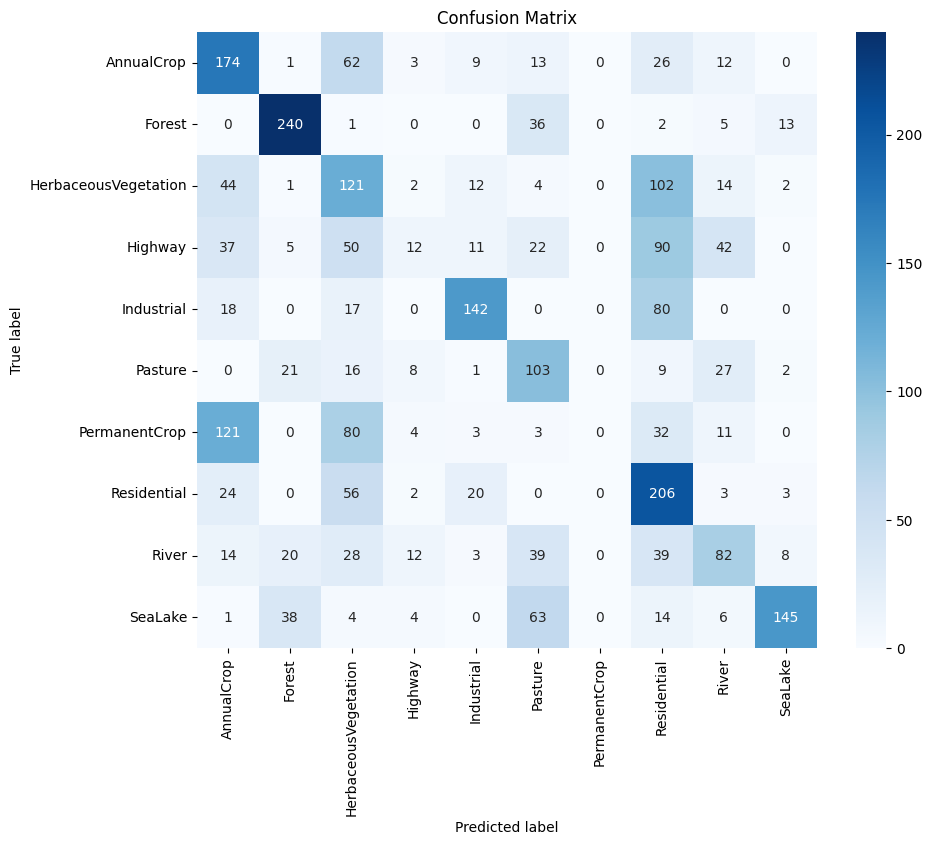

In [ ]:
# 1. Load the best model state
mlp_model.load_state_dict(best_mlp_model_state)
mlp_model.eval() # Set the model to evaluation mode

# 2. Evaluate the model on the test set
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3. Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

# 4. Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Navzdory nepřílíš vysoké přesnosti MLP modelu je z grafu níže patrné, že nedocházelo k fluktuacím ani přeučení.

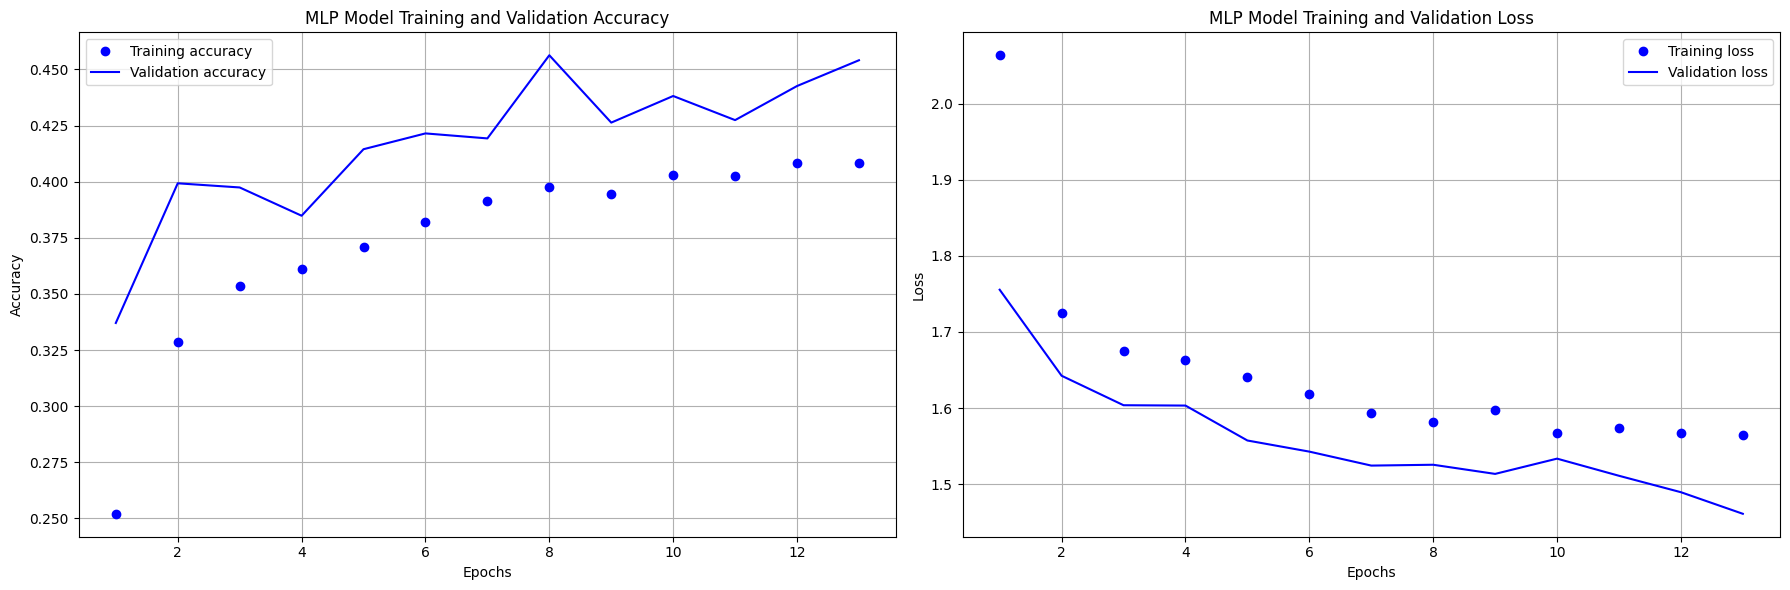

In [ ]:
plot_training_history(mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies, model_name="MLP Model")

Testovací přesnost pro nejlepší MLP model první (slabší) architektury.

In [ ]:
import torch
from torch import nn

# 1. Nejlepší uložený model
mlp_model.load_state_dict(best_mlp_model_state)
mlp_model.to(device)
mlp_model.eval()

# 2. Vyhodnocení přesnosti na testovacím datasetu
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp_model(images)
        predicted = outputs.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 45.37%


2. silnější architektura MLP

cílem u této architektury bylo dosáhnout co nejlepšího výsledku s MLP a pokud možno se přiblížit výsledkům CNN nebo ViT

Pro stabilizaci trénování a sjednocení měřítka vstupních dat byla použita normalizace vstupních obrazů. Hodnoty průměru i dochylky byly získány z odkazu:https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2?utm_source=chatgpt.com


In [ ]:
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

])
train_dataset = CustomImageDataset(train_base, transform=base_transform)
val_dataset   = CustomImageDataset(val_base,   transform=base_transform)
test_dataset  = CustomImageDataset(test_base,  transform=base_transform)


In [ ]:
import torch
import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*64*3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)



    def forward(self, x):
        x = self.flatten(x)        # (B, 12288)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [ ]:
# vytvoření instance modelu
mlp_model = MLPNet().to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(mlp_model.parameters(), lr=3e-4, weight_decay=5e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # sledujeme validation loss
    factor=0.4,      # sníží LR na 0.4 původní hodnoty
    patience=2       # počká 2 epochy bez zlepšení
)

# Early stopping parameters
patience = 5
min_delta = 0.0
epochs_to_train = 30

print("\n--- Training MLP Model ---")
best_mlp_model_state, mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies = \
    train_model(
        model=mlp_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience,
        min_delta=min_delta,
        scheduler=scheduler
    )



--- Training MLP Model ---
Epoch 1/30 | Train Loss: 1.8228 | Train Acc: 0.3941 | Val Loss: 1.5898 | Val Acc: 0.5356
  -> Validation accuracy improved, saving model.
Epoch 2/30 | Train Loss: 1.6155 | Train Acc: 0.4991 | Val Loss: 1.4935 | Val Acc: 0.5730
  -> Validation accuracy improved, saving model.
Epoch 3/30 | Train Loss: 1.5501 | Train Acc: 0.5355 | Val Loss: 1.4619 | Val Acc: 0.5826
  -> Validation accuracy improved, saving model.
Epoch 4/30 | Train Loss: 1.5113 | Train Acc: 0.5570 | Val Loss: 1.4037 | Val Acc: 0.6181
  -> Validation accuracy improved, saving model.
Epoch 5/30 | Train Loss: 1.4870 | Train Acc: 0.5684 | Val Loss: 1.3917 | Val Acc: 0.6167
  -> No improvement for 1 epochs.
Epoch 6/30 | Train Loss: 1.4588 | Train Acc: 0.5847 | Val Loss: 1.3693 | Val Acc: 0.6237
  -> Validation accuracy improved, saving model.
Epoch 7/30 | Train Loss: 1.4348 | Train Acc: 0.5942 | Val Loss: 1.3969 | Val Acc: 0.6000
  -> No improvement for 1 epochs.
Epoch 8/30 | Train Loss: 1.4246 | Tr

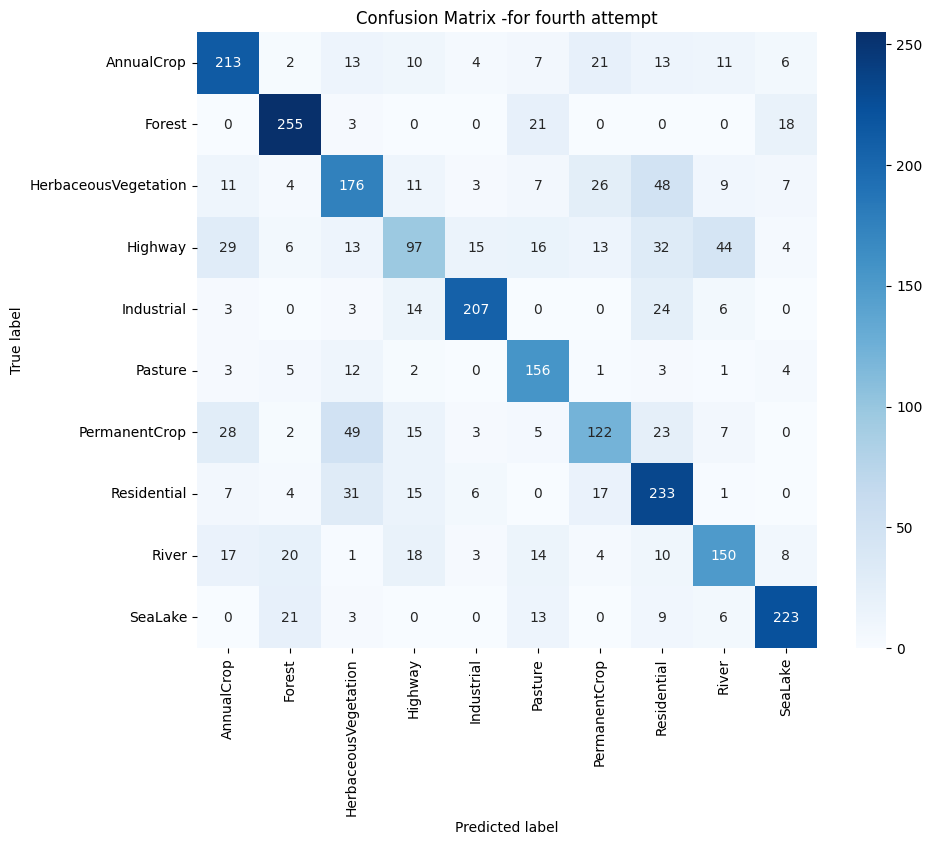

In [ ]:
# 1. Load the best model state
mlp_model.load_state_dict(best_mlp_model_state)
mlp_model.eval() # Set the model to evaluation mode

# 2. Evaluate the model on the test set
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3. Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

# 4. Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix -for fourth attempt')
plt.show()

U prvního pokusu byl, jak je vidět na grafech, problém přeučení. Pro řešení overfitingu, byl zvýšen dropout na 0,5 a weight decay na 5e-2.

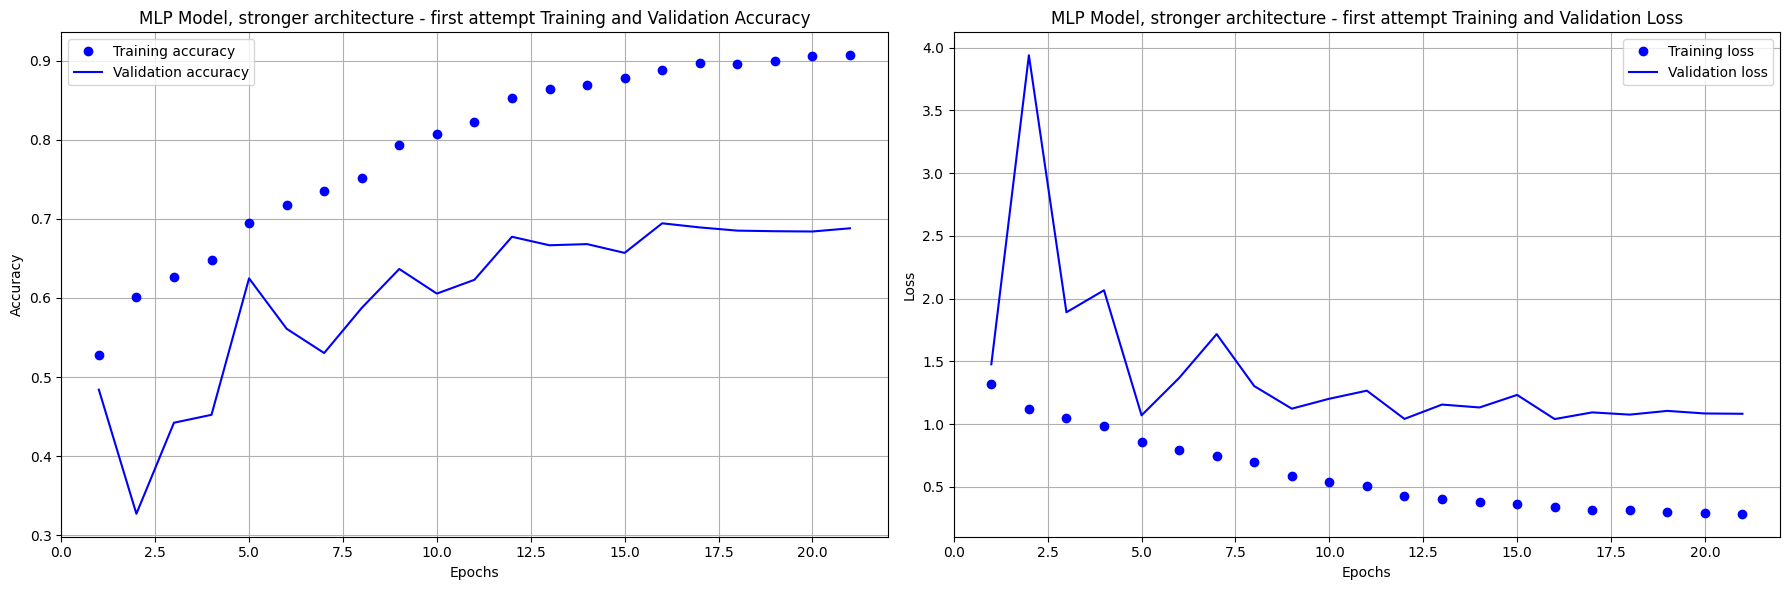

In [ ]:
plot_training_history(mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies, model_name="MLP Model, stronger architecture - first attempt")

Zvýšení weight decay a dropout, problém s přeučením nevyřešilo, proto byla pro další pokus upravna architektura. Původní počet neuronů ve vrstvách (2048 → 516 → 10) byl upraven na 1024 → 256 → 10. Byl také použit label smoothing (label_smoothing=0.1)

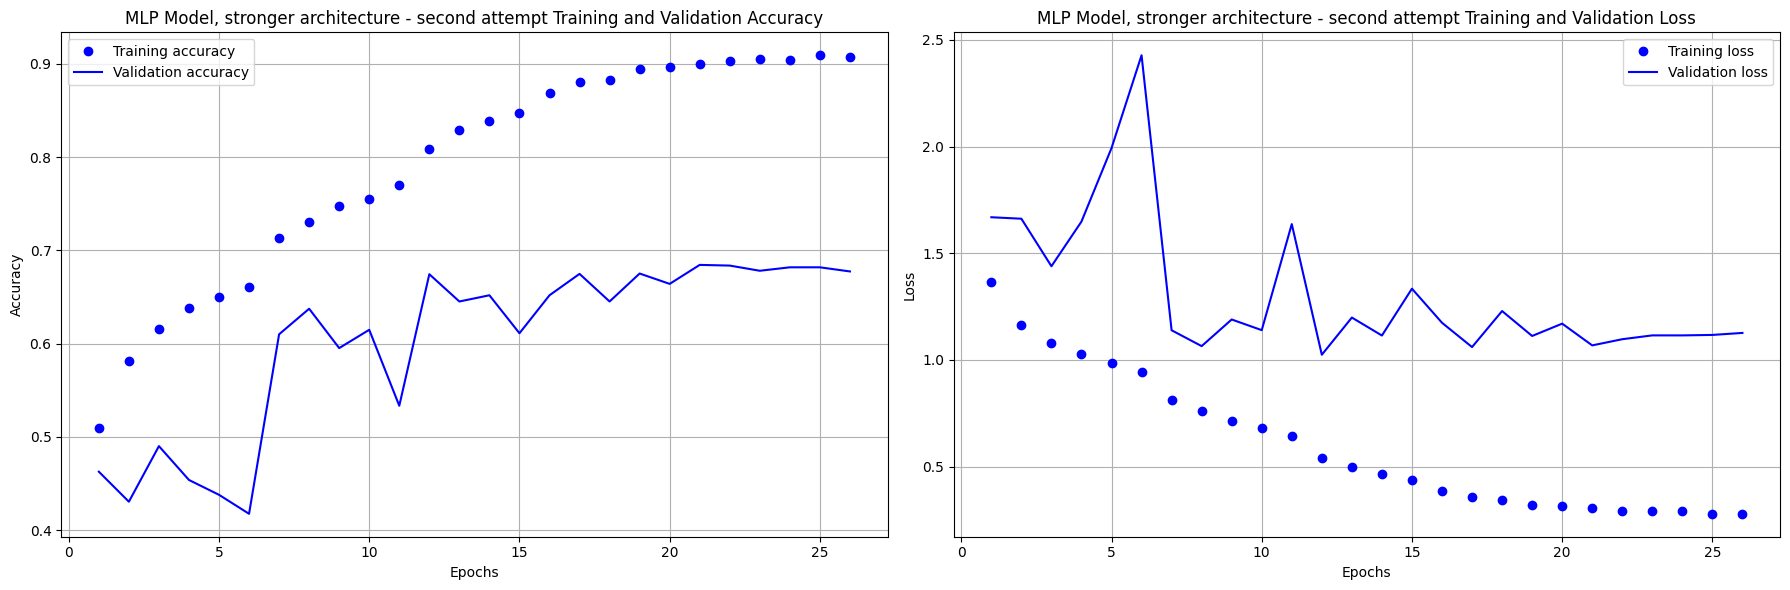

In [ ]:
plot_training_history(mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies, model_name="MLP Model, stronger architecture - second attempt")

Pro další pokus byla upravena architektura -> přidán dropout i po první vrstvě, snížen počet neuronů 512 → 128 → 10, úprava learning rate na 3e-4, zároveň přidána normalizace tensoru

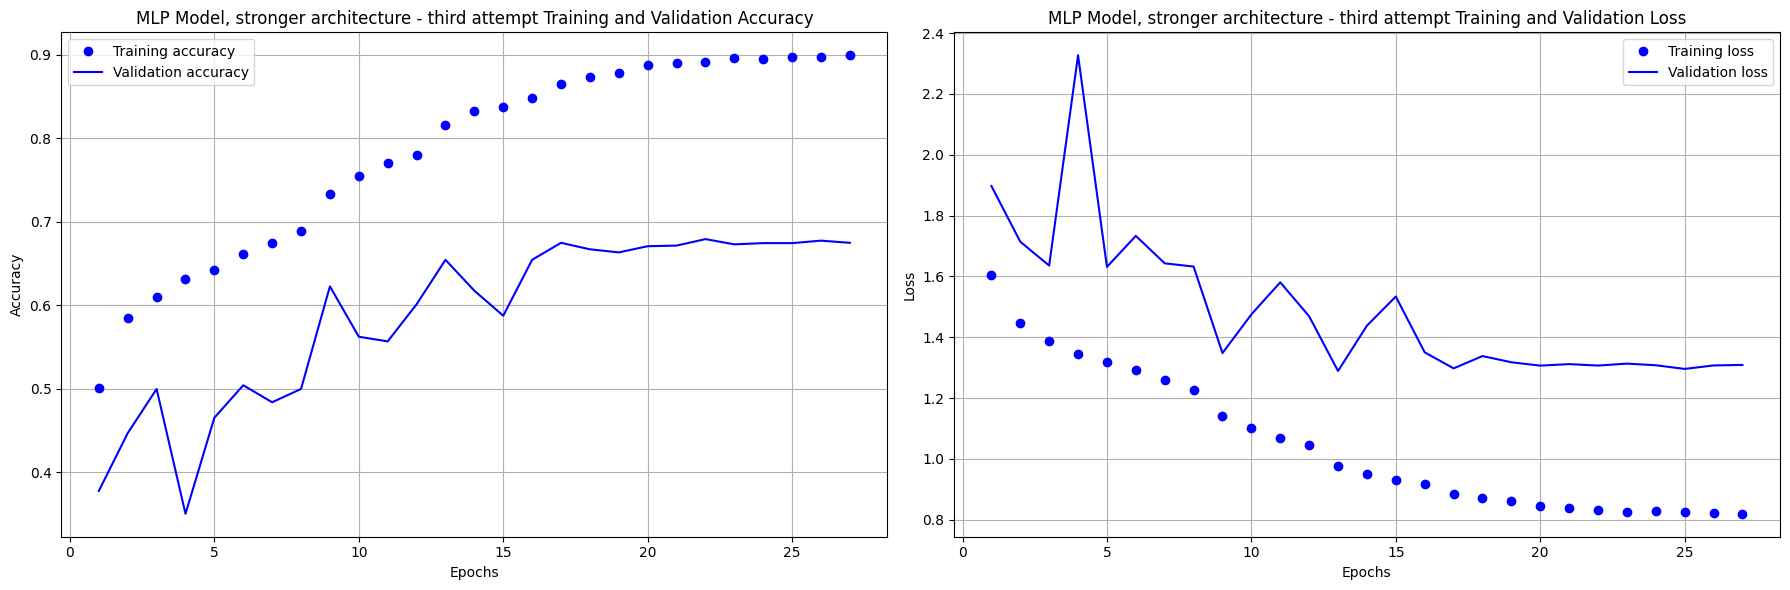

In [ ]:
plot_training_history(mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies, model_name="MLP Model, stronger architecture - third attempt")

Jak je vidět u poslední dvojice grafů, snížení počtu neuronů, normalizace vstupů snížení LR vedlo k vyřešení overfitingu modelu. Je však nutné poznamenat, že výsledná přesnost modelu (cca 67 % na testovacím datasetu) nedosahuje takových výsledků jako CNN nebo ViT.

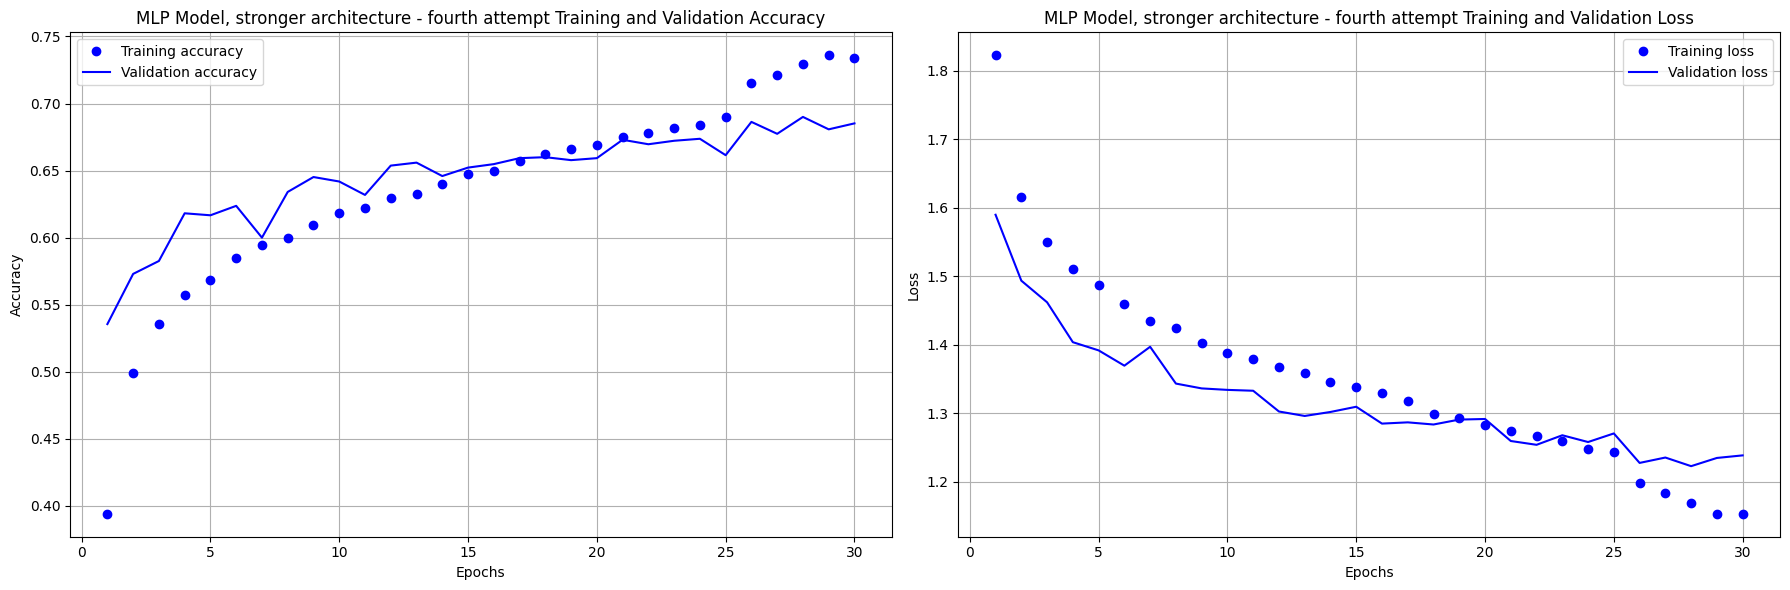

In [ ]:
plot_training_history(mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies, model_name="MLP Model, stronger architecture - fourth attempt")

In [ ]:
import torch
from torch import nn

# 1. Nejlepší uložený model
mlp_model.load_state_dict(best_mlp_model_state)
mlp_model.to(device)
mlp_model.eval()

# 2. Vyhodnocení přesnosti na testovacím datasetu
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp_model(images)
        predicted = outputs.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 67.85%


3. část - Vision transformer


Předmětem této části je využití předtrénovaného vision transofrmeru a natrénování pouze klasifikační hlavy (linear probing).

Poznámka k výběru ViT. Byl vybrán vit_base_patch16_224. Jde o často využívaný transformer vhodný pro daný dataset co do rozsahu i pro možnosti porovnávání. https://arxiv.org/abs/2010.11929

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

base_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Změna velikosti na 224x224 pro ViT
    transforms.ToTensor(),
])
train_dataset = CustomImageDataset(train_base, transform=base_transform)
val_dataset = CustomImageDataset(val_base, transform=base_transform)
test_dataset = CustomImageDataset(test_base, transform=base_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

kod níže definuje architekturu pro Vision Transformer. Jde o zamrazení samotného transformeru a vytvoření vlastní klasifikační hlavy.

In [ ]:
import torch
from torch import nn

class ConvNetViT(nn.Module):
    def __init__(self, vit_base, num_classes=10):
        super().__init__()

        # Freeze backbone
        for param in vit_base.parameters():
            param.requires_grad = False #trénování se netýká samotného transformeru

        # odebrání původní klasifikační hlavy, takže budeme místo embeddingů dostávat CLS token
        feature_size = vit_base.head.in_features
        vit_base.head = nn.Identity()

        self.vit_base = vit_base

        # Vytvoření klasifikační hlavy
        self.classifier = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.vit_base(x)  # vrací CLS token
        return self.classifier(features)

Vytvoření předténovaného ViT vit_base_patch16_224. Vytvoření nové instance třídy s architekturou.

In [ ]:
import timm

# vytvoření pretrained ViT backbone
vit_base = timm.create_model("vit_base_patch16_224", pretrained=True)

# nová instance třídy
model = ConvNetViT(vit_base=vit_base, num_classes=10)  # 1 pro binary klasifikaci
print(model)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to: {device}")


ConvNetViT(
  (vit_base): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (

In [ ]:
import torch
import torch.optim as optim
import copy

def train_model(model, criterion, optimizer,
                train_loader, validation_loader,
                epochs, device, patience, min_delta,
                scheduler=None):

    best_val_accuracy = float('-inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for e in range(epochs):
        # ---------- TRAIN ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)          # logits [B, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss_epoch = running_loss / max(1, len(train_loader))
        train_acc_epoch  = correct_train / max(1, total_train)
        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_acc_epoch)

        # ---------- VALIDATION ----------
        model.eval()
        val_loss_sum = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_sum += loss.item()

                predicted = outputs.argmax(dim=1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        current_val_loss = val_loss_sum / max(1, len(validation_loader))
        current_val_accuracy = correct_val / max(1, total_val)
        val_losses.append(current_val_loss)
        val_accuracies.append(current_val_accuracy)

        # ---------- SCHEDULER ----------
        if scheduler is not None:
            scheduler.step(current_val_loss)

        print(f"Epoch {e+1}/{epochs} | "
              f"Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc_epoch:.4f} | "
              f"Val Loss: {current_val_loss:.4f} | Val Acc: {current_val_accuracy:.4f}")

        # ---------- EARLY STOPPING ----------
        if current_val_accuracy > best_val_accuracy + min_delta:
            best_val_accuracy = current_val_accuracy
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            print("  -> Validation accuracy improved, saving model.")
        else:
            epochs_no_improve += 1
            print(f"  -> No improvement for {epochs_no_improve} epochs.")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {e+1} epochs.")
                break

    if best_model_state is None:
        best_model_state = copy.deepcopy(model.state_dict())
        print("No improvement observed, returning the last model state.")
    else:
        print("Returning model state with the best validation accuracy.")

    return best_model_state, train_losses, val_losses, train_accuracies, val_accuracies


Trénování ViT (klasifikační hlavy).
V této části (ViT) sice bylo zvoleno jen 6 epoch, nicméně navzdory tomu je vidět, že model v poslední epoše překonává CNN z první části. (Jde o marginální zlepšení, což je však dáno vysokou výkonností prnvího modelu).
Kromě poslední epochy je dobré si všimnout i té první, u které je vidět, že model má přesnost již 93 % u validačních dat. Je to pochopitelně dáno tím, že ViT je již předténovaný.


In [ ]:
import torch
import torch.optim as optim
import copy

#definování modelu
ViT_model = model


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, ViT_model.parameters()), # výběr parametrů, které se mají učit (parametry klasifikační hlavy)
    lr=3e-4,
    weight_decay=0.05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # sledujeme validation loss
    factor=0.4,      # sníží LR na 0.4 původní hodnoty
    patience=2       # počká 2 epochy bez zlepšení
)

# Early stopping parameters
patience = 2
min_delta = 0.0
epochs_to_train = 6

print("\n--- Training ViT Model ---")
best_ViT_model_state, ViT_train_losses, ViT_val_losses, ViT_train_accuracies, ViT_val_accuracies = \
    train_model(
        model=ViT_model, # Changed from cnn_model to ViT_model
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience,
        min_delta=min_delta,
        scheduler=scheduler
    )


--- Training ViT Model ---
Epoch 1/6 | Train Loss: 0.4681 | Train Acc: 0.8569 | Val Loss: 0.2024 | Val Acc: 0.9300
  -> Validation accuracy improved, saving model.
Epoch 2/6 | Train Loss: 0.2012 | Train Acc: 0.9367 | Val Loss: 0.1470 | Val Acc: 0.9507
  -> Validation accuracy improved, saving model.
Epoch 3/6 | Train Loss: 0.1561 | Train Acc: 0.9526 | Val Loss: 0.1265 | Val Acc: 0.9574
  -> Validation accuracy improved, saving model.
Epoch 4/6 | Train Loss: 0.1336 | Train Acc: 0.9564 | Val Loss: 0.1164 | Val Acc: 0.9600
  -> Validation accuracy improved, saving model.
Epoch 5/6 | Train Loss: 0.1153 | Train Acc: 0.9639 | Val Loss: 0.1124 | Val Acc: 0.9585
  -> No improvement for 1 epochs.
Epoch 6/6 | Train Loss: 0.1040 | Train Acc: 0.9677 | Val Loss: 0.1084 | Val Acc: 0.9615
  -> Validation accuracy improved, saving model.
Returning model state with the best validation accuracy.


I u Vision transformeru byla vytvořena matice záměn. Ta prozrazuje, že model si téměř bezchybně s klasifikací daného datasteu poradí. Za povšimnutí stojí záměna třídy highway s river.

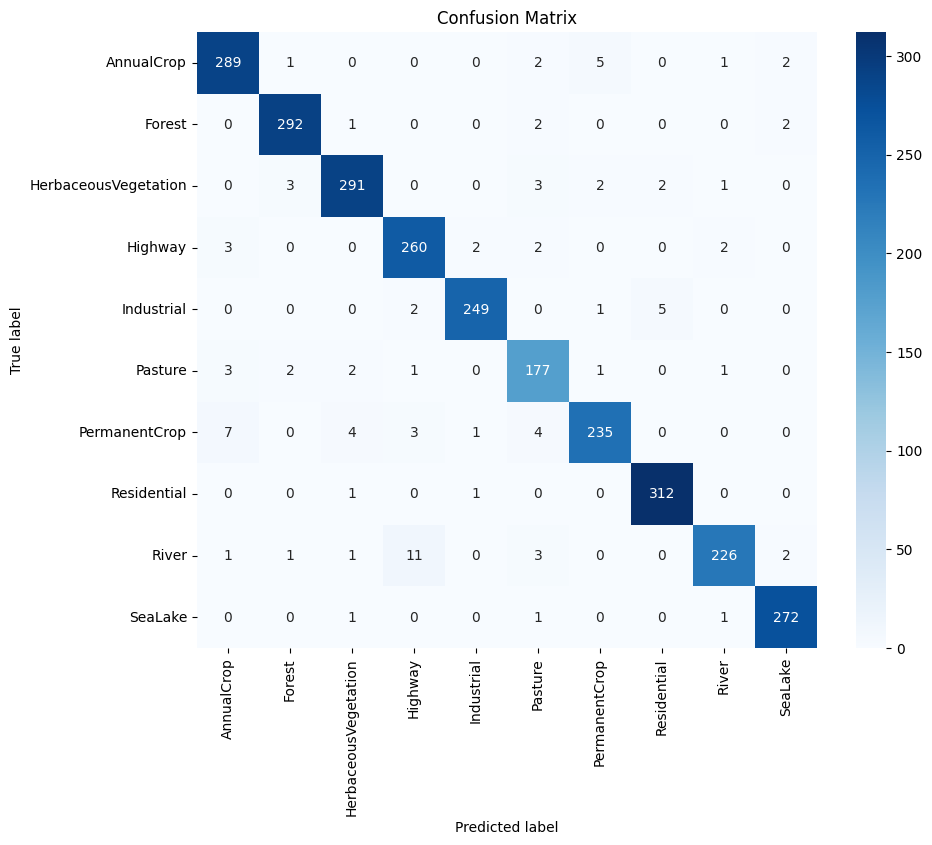

In [ ]:

# 1. Load the best model state
ViT_model.load_state_dict(best_ViT_model_state)
ViT_model.eval() # Set the model to evaluation mode

# 2. Evaluate the model on the test set
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = ViT_model(images) # Changed from cnn_model(images) to ViT_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3. Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

# 4. Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

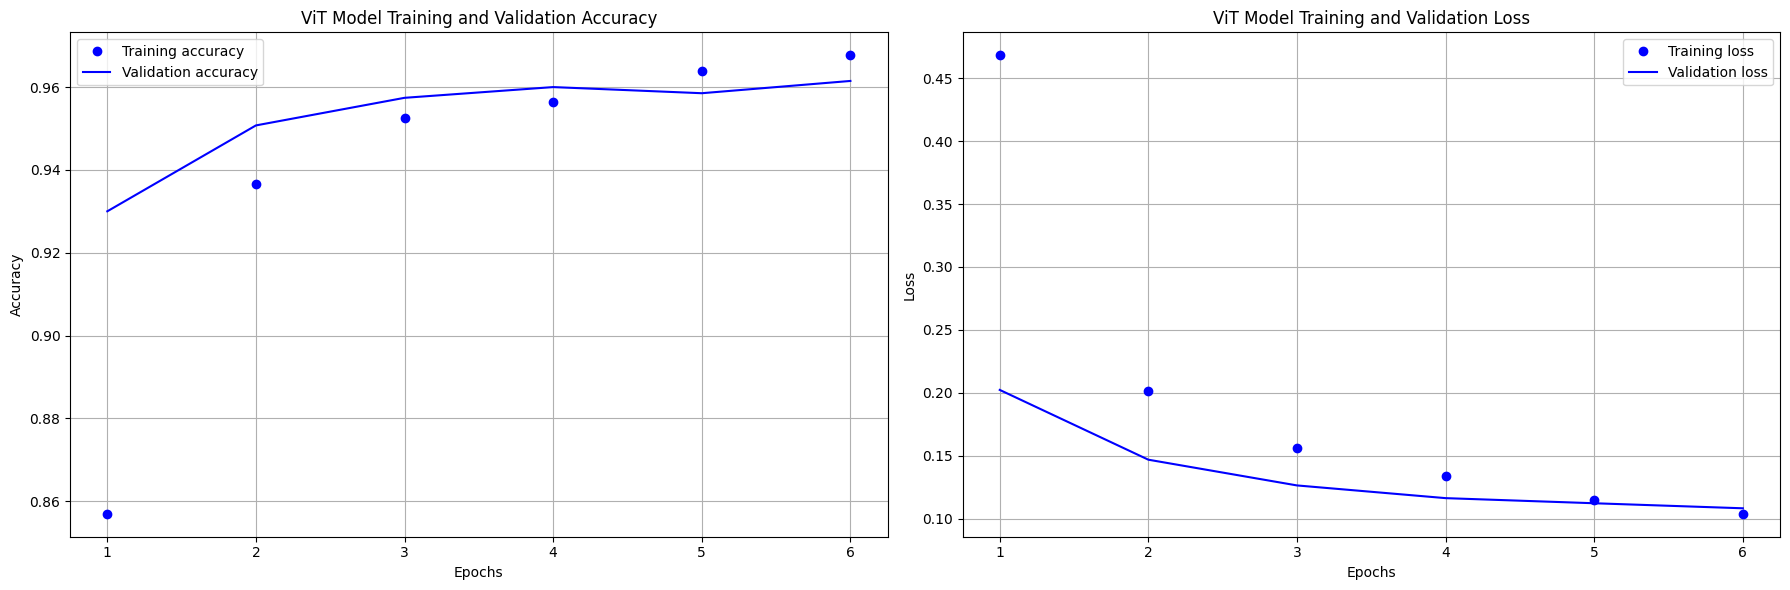

In [ ]:
plot_training_history(ViT_train_losses, ViT_val_losses, ViT_train_accuracies, ViT_val_accuracies, model_name="ViT Model")

Přesnost ViT na testovacích datech.

In [ ]:
import torch
from torch import nn

# 1. Nahraní nejlepšího modelu
ViT_model.load_state_dict(best_ViT_model_state)
ViT_model.to(device)
ViT_model.eval()

# 2. Vyhodnocení přesnosti na testovacím datasetu
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = ViT_model(images)
        predicted = outputs.argmax(dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 96.41%


4. část - MLP randomSearch
Cílem této části je otestovat, jak se změní výkon slabšího modelu otestovaného v 2. části při randomSearch.

In [ ]:
#test

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Definování hodnot pro randomSeach. Byly zvoleny tyto hodnoty jako kompromis mezi testování a výpočetní/časovou náročností. Dále byl nastaven počet běhů na 10. Napříč všemi 10 běhy je možné pozorovat, že přesnost modelu se oproti původnímu MLP modelu z 2.části (který měl přesnost okolo 45 %) mírně zvyšuje (v závislosti na konkrétním běhu). Je evidentní že pro výrazné zlepšení by byla potřeba robustnější architektura modelu.

In [ ]:
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim

# values
search_space = {
    "lr": [1e-4, 3e-4, 1e-3, 3e-3],
    "weight_decay": [0.0, 1e-4, 1e-3, 1e-2],
    "factor": [0.3, 0.4, 0.5],
    "patience_scheduler": [1, 2, 3]
}

n_trials = 10

best_val_loss = float("inf")
best_config = None
best_model_state = None


criterion = nn.CrossEntropyLoss()

best_train_losses = None
best_val_losses = None
best_train_accuracies = None
best_val_accuracies = None

for trial in range(n_trials):

    # náhodný výběr hyperparametru
    lr = random.choice(search_space["lr"])
    weight_decay = random.choice(search_space["weight_decay"])
    factor = random.choice(search_space["factor"])
    patience_sched = random.choice(search_space["patience_scheduler"])

    # fixní patience pro early stopping
    patience_es = 3

    # model
    mlp_model = MLPNet().to(device)

    # definování optimazeru
    optimizer = optim.AdamW(
        mlp_model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    #  scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=factor,
        patience=patience_sched
    )

    # training params
    min_delta = 0.0
    epochs_to_train = 30

    print(
        f"\n--- Trial {trial+1}/{n_trials} | "
        f"lr={lr}, wd={weight_decay}, factor={factor}, "
        f"pat_sched={patience_sched}, pat_es={patience_es} ---"
    )

    # --- training ---
    best_mlp_model_state, mlp_train_losses, mlp_val_losses, \
    mlp_train_accuracies, mlp_val_accuracies = train_model(
        model=mlp_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience_es,      # early stopping = 3
        min_delta=min_delta,
        scheduler=scheduler
    )

    # --- evaluate trial ---
    trial_best_val_loss = min(mlp_val_losses)

    if trial_best_val_loss < best_val_loss:
        best_train_losses = mlp_train_losses
        best_val_losses = mlp_val_losses
        best_train_accuracies = mlp_train_accuracies
        best_val_accuracies = mlp_val_accuracies
        best_val_loss = trial_best_val_loss
        best_config = {
            "lr": lr,
            "weight_decay": weight_decay,
            "factor": factor,
            "patience_scheduler": patience_sched,
            "patience_earlystop": patience_es
        }
        best_model_state = copy.deepcopy(best_mlp_model_state)

        best_val_acc = max(mlp_val_accuracies)

        print(
            f"New best trial | "
            f"best_val_loss = {best_val_loss:.6f}, "
            f"best_val_acc = {best_val_acc:.4f}"
        )

print("\n=== BEST OVERALL MODEL ===")
print("Best config:", best_config)
print("Best val loss:", best_val_loss)



--- Trial 1/10 | lr=0.0001, wd=0.0001, factor=0.3, pat_sched=2, pat_es=3 ---
Epoch 1/30 | Train Loss: 1.8864 | Train Acc: 0.2762 | Val Loss: 1.7530 | Val Acc: 0.2981
  -> Validation accuracy improved, saving model.
Epoch 2/30 | Train Loss: 1.7280 | Train Acc: 0.3400 | Val Loss: 1.6861 | Val Acc: 0.3811
  -> Validation accuracy improved, saving model.
Epoch 3/30 | Train Loss: 1.6523 | Train Acc: 0.3833 | Val Loss: 1.6062 | Val Acc: 0.4093
  -> Validation accuracy improved, saving model.
Epoch 4/30 | Train Loss: 1.5952 | Train Acc: 0.4083 | Val Loss: 1.5759 | Val Acc: 0.4107
  -> Validation accuracy improved, saving model.
Epoch 5/30 | Train Loss: 1.5649 | Train Acc: 0.4231 | Val Loss: 1.5349 | Val Acc: 0.4396
  -> Validation accuracy improved, saving model.
Epoch 6/30 | Train Loss: 1.5364 | Train Acc: 0.4314 | Val Loss: 1.5383 | Val Acc: 0.4407
  -> Validation accuracy improved, saving model.
Epoch 7/30 | Train Loss: 1.5221 | Train Acc: 0.4366 | Val Loss: 1.5252 | Val Acc: 0.4337
  -> 

Graf zachycuje vývoj přesnosti nejlepšího běhu random search.

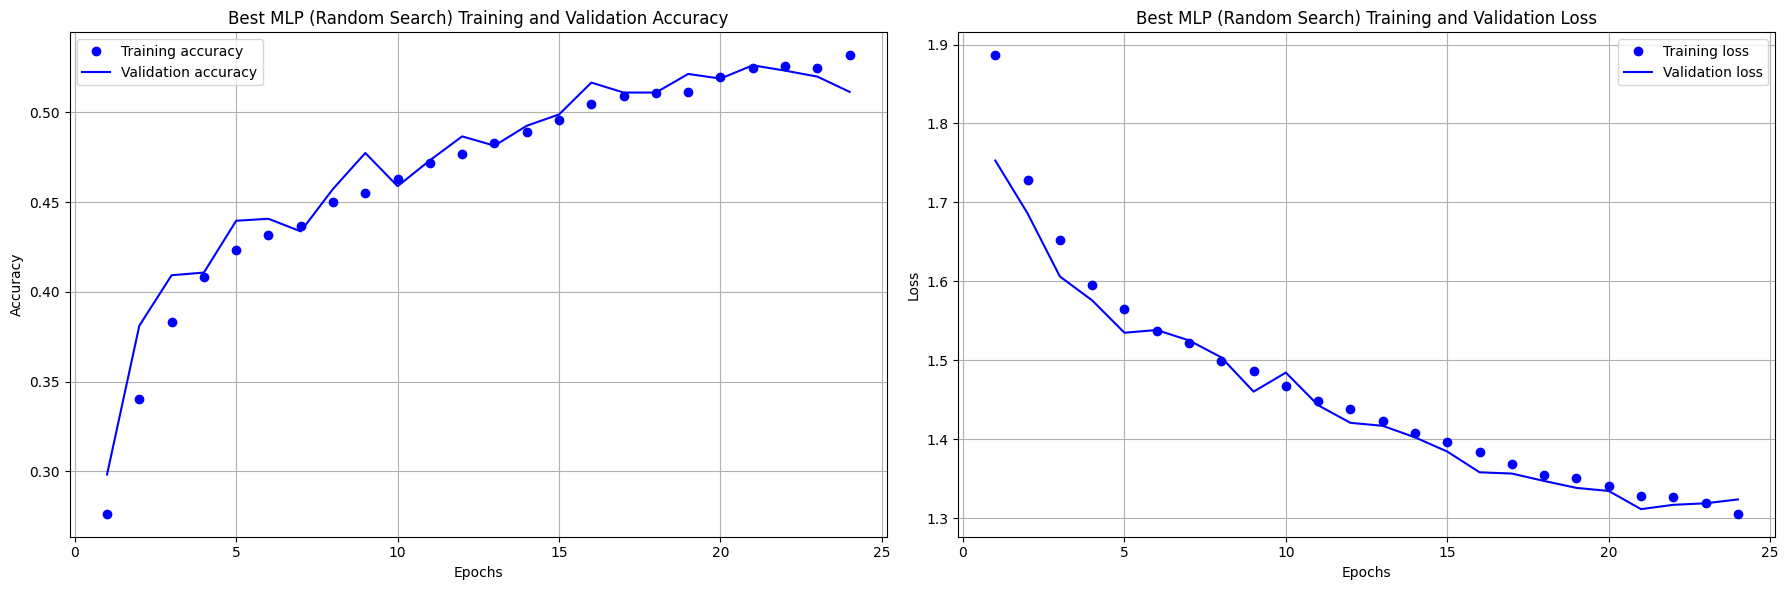

In [ ]:
plot_training_history(
    best_train_losses,
    best_val_losses,
    best_train_accuracies,
    best_val_accuracies,
    model_name="Best MLP (Random Search)"
)


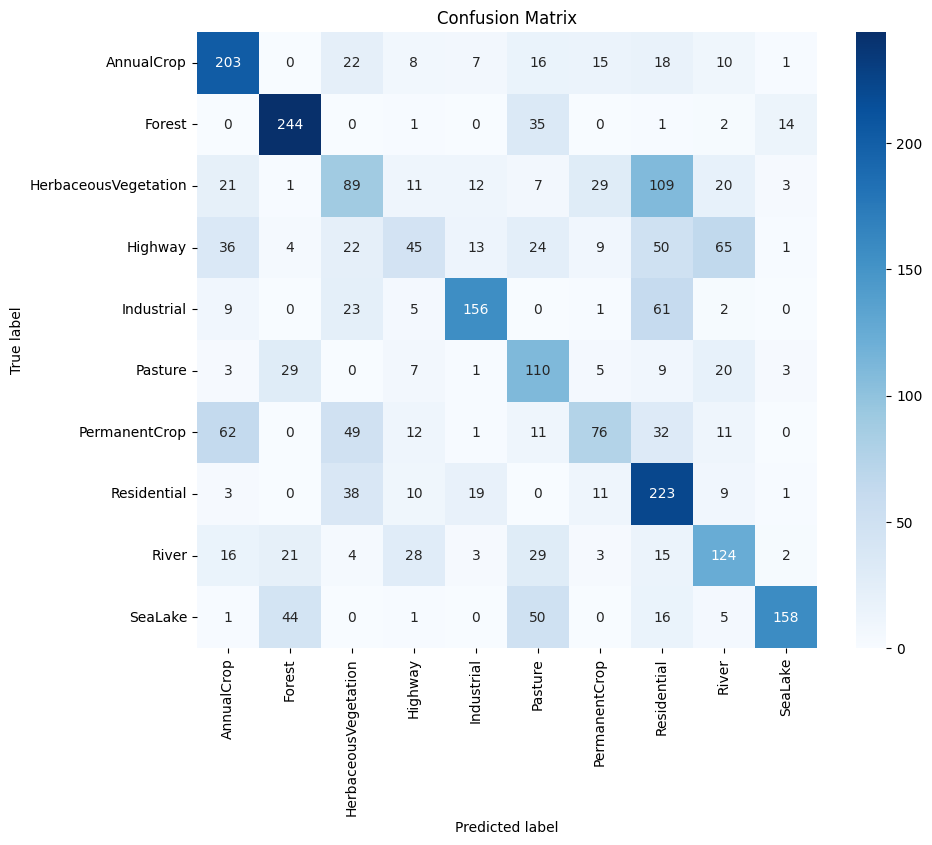

In [ ]:
# 1) načtení nejlepšího modelu
best_mlp_model = MLPNet().to(device)
best_mlp_model.load_state_dict(best_model_state)
best_mlp_model.eval()

# 2) evaluace na testovacím datasetu
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_mlp_model(images)
        predicted = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3) Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


data augmentation
5. část - data augmentation
Tato část si klade za cíl otestovat vliv data augmentation na vybraný dataset. Vzhledem k faktu, že původní CNN model má vysokou výkonnost a je regularizovaný, byla v této části vytvořena další, záměrně horší architektura, na které bude možné pozorovat vliv data augmentation.

In [ ]:
import torch
from torch import nn

class ConvNet1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 64x64 -> 64x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # -> 32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> 32x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                             # -> 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

cnn = ConvNet1()

print(cnn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
print(f"Model moved to: {device}")


from torchsummary import summary
print("Model Summary:")
print(summary(cnn, (3, 64, 64), device=str(device)))



ConvNet1(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
Model moved to: cuda
Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
         MaxPool2d-3           [-1, 16, 32, 32]               0
  

In [ ]:
# instance modelu
cnn_model = ConvNet1().to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # sledujeme validation loss
    factor=0.4,      # snížení LR na 0.4 původní hodnoty
    patience=2       # počká 2 epochy bez zlepšení
)

# Early stopping parameters
patience = 5
min_delta = 0.0
epochs_to_train = 30

print("\n--- Training CNN Model ---")
best_cnn_model_state, cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = \
    train_model(
        model=cnn_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience,
        min_delta=min_delta,
        scheduler=scheduler
    )



--- Training CNN Model ---
Epoch 1/30 | Train Loss: 1.3732 | Train Acc: 0.4906 | Val Loss: 0.9671 | Val Acc: 0.6504
  -> Validation accuracy improved, saving model.
Epoch 2/30 | Train Loss: 0.8646 | Train Acc: 0.6867 | Val Loss: 0.7876 | Val Acc: 0.7196
  -> Validation accuracy improved, saving model.
Epoch 3/30 | Train Loss: 0.7319 | Train Acc: 0.7337 | Val Loss: 0.6888 | Val Acc: 0.7563
  -> Validation accuracy improved, saving model.
Epoch 4/30 | Train Loss: 0.6575 | Train Acc: 0.7623 | Val Loss: 0.6986 | Val Acc: 0.7441
  -> No improvement for 1 epochs.
Epoch 5/30 | Train Loss: 0.6237 | Train Acc: 0.7739 | Val Loss: 0.5968 | Val Acc: 0.7819
  -> Validation accuracy improved, saving model.
Epoch 6/30 | Train Loss: 0.5707 | Train Acc: 0.7935 | Val Loss: 0.6548 | Val Acc: 0.7633
  -> No improvement for 1 epochs.
Epoch 7/30 | Train Loss: 0.5522 | Train Acc: 0.8029 | Val Loss: 0.5590 | Val Acc: 0.8007
  -> Validation accuracy improved, saving model.
Epoch 8/30 | Train Loss: 0.5003 | Tr

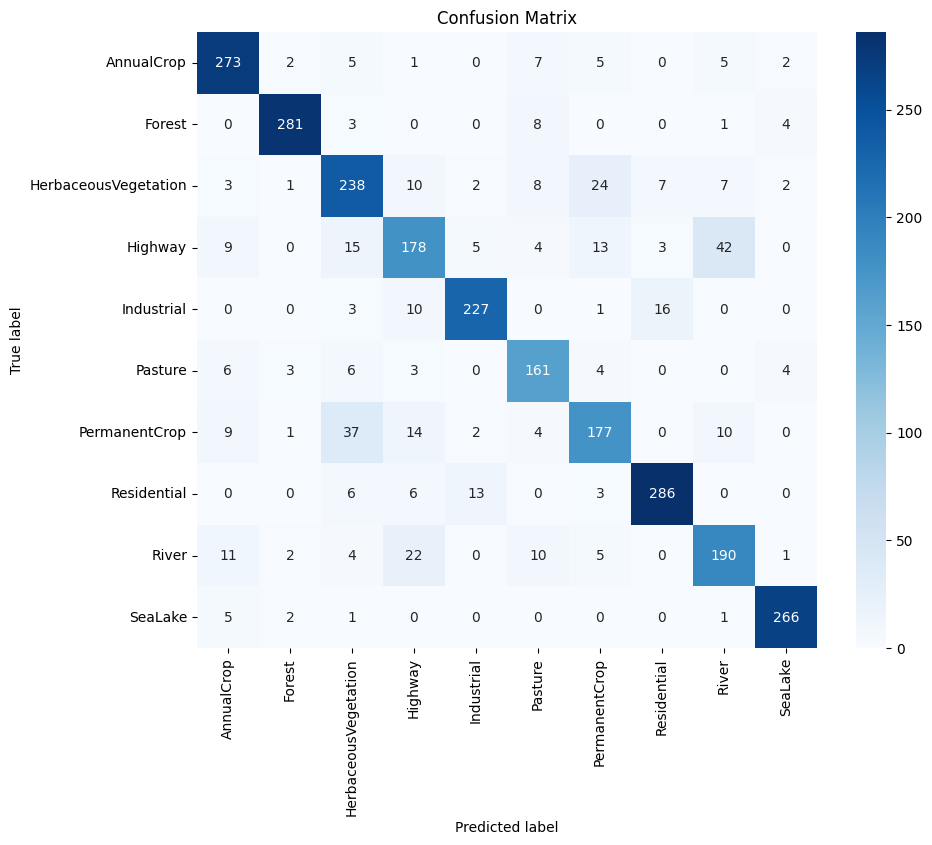

In [ ]:
# 1. Load the best model state
cnn_model.load_state_dict(best_cnn_model_state)
cnn_model.eval() # Set the model to evaluation mode

# 2. Evaluate the model on the test set
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3. Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

# 4. Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

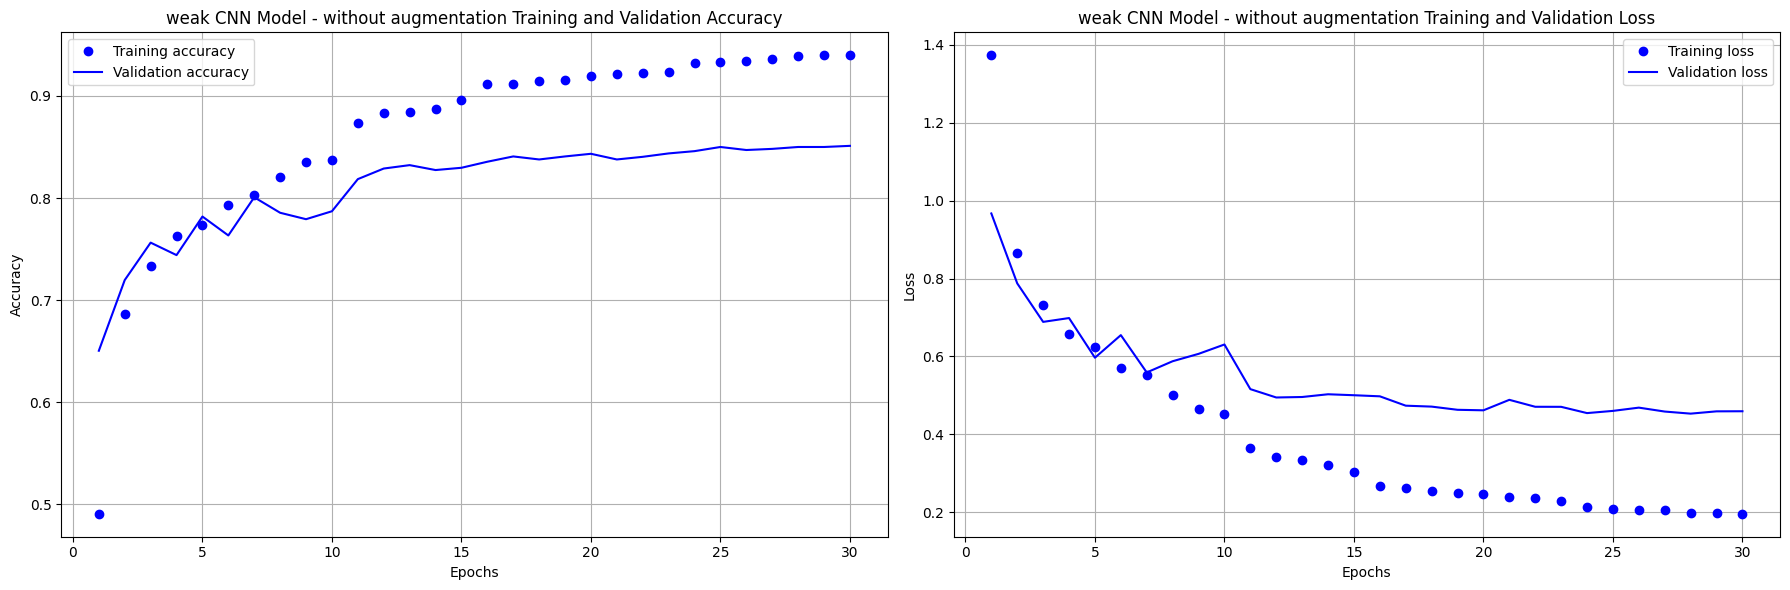

In [ ]:
plot_training_history(cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies, model_name="weak CNN Model - without augmentation")

In [ ]:
#definování transformeru pro trénovací sadu - prohození, otočení, scaling

In [ ]:
from torchvision import transforms

IMAGE_SIZE = 64  # Define IMAGE_SIZE for CNN input (64x64)

base_transform = transforms.Compose([
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(
        size=IMAGE_SIZE,
        scale=(0.8, 1.0)
    ),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(
    train_base,
    transform=train_transform
)

val_dataset = CustomImageDataset(
    val_base,
    transform=base_transform
)

test_dataset = CustomImageDataset(
    test_base,
    transform=base_transform
)


In [ ]:
#dataloadery
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True, pin_memory=True)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Trénování CNN modelu s data augmentation.

In [ ]:
# Create an instance of your CNN model
cnn_model = ConvNet1().to(device)

# Define your criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=1e-2)  # 1e-3 je bezpečnější než 1e-2

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # sledujeme validation loss
    factor=0.4,      # sníží LR na 0.4 původní hodnoty
    patience=2       # počká 2 epochy bez zlepšení
)

# Early stopping parameters
patience = 5
min_delta = 0.0
epochs_to_train = 30

print("\n--- Training CNN Model ---")
best_cnn_model_state, cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = \
    train_model(
        model=cnn_model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_dataloader,
        validation_loader=validation_dataloader,
        epochs=epochs_to_train,
        device=device,
        patience=patience,
        min_delta=min_delta,
        scheduler=scheduler
    )



--- Training CNN Model ---
Epoch 1/30 | Train Loss: 1.4264 | Train Acc: 0.4730 | Val Loss: 1.1510 | Val Acc: 0.5830
  -> Validation accuracy improved, saving model.
Epoch 2/30 | Train Loss: 1.0040 | Train Acc: 0.6388 | Val Loss: 0.8918 | Val Acc: 0.6822
  -> Validation accuracy improved, saving model.
Epoch 3/30 | Train Loss: 0.8602 | Train Acc: 0.6844 | Val Loss: 0.7948 | Val Acc: 0.7170
  -> Validation accuracy improved, saving model.
Epoch 4/30 | Train Loss: 0.7774 | Train Acc: 0.7126 | Val Loss: 0.8777 | Val Acc: 0.6804
  -> No improvement for 1 epochs.
Epoch 5/30 | Train Loss: 0.7383 | Train Acc: 0.7285 | Val Loss: 0.7132 | Val Acc: 0.7278
  -> Validation accuracy improved, saving model.
Epoch 6/30 | Train Loss: 0.7017 | Train Acc: 0.7413 | Val Loss: 0.7126 | Val Acc: 0.7452
  -> Validation accuracy improved, saving model.
Epoch 7/30 | Train Loss: 0.6524 | Train Acc: 0.7644 | Val Loss: 0.7115 | Val Acc: 0.7448
  -> No improvement for 1 epochs.
Epoch 8/30 | Train Loss: 0.6280 | Tr

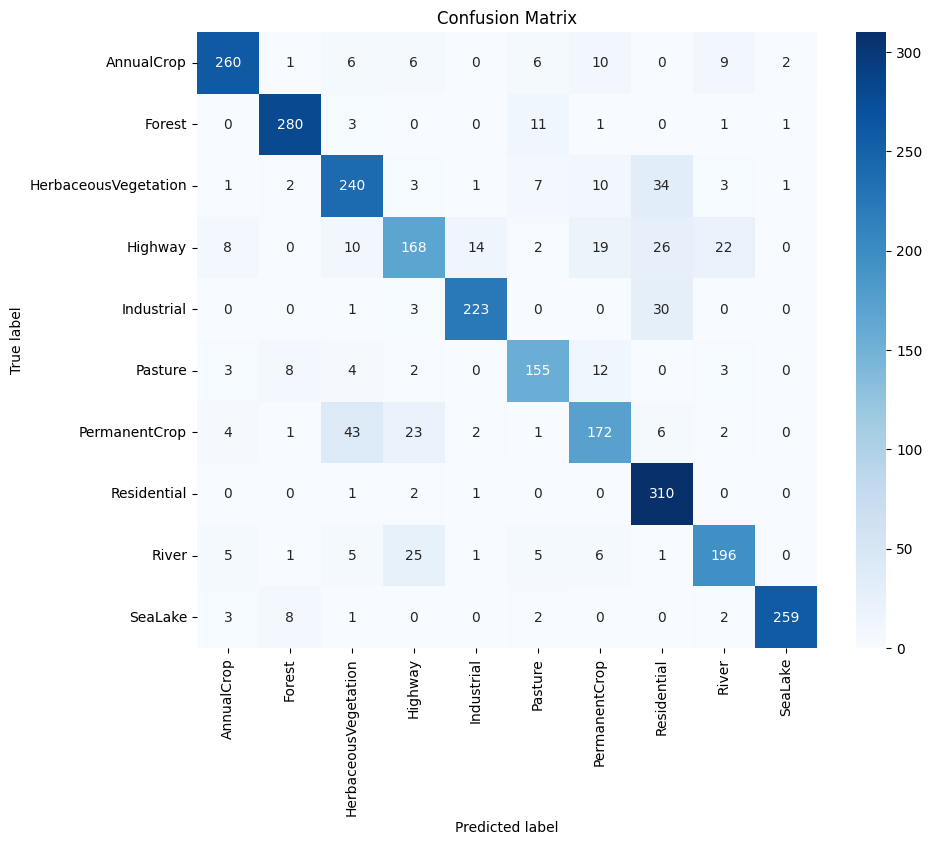

In [ ]:
# 1. Load the best model state
cnn_model.load_state_dict(best_cnn_model_state)
cnn_model.eval() # Set the model to evaluation mode

# 2. Evaluate the model on the test set
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 3. Generate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)

# 4. Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Na grafech si lze všimnout, že dochází k více fluktuacím, zároveň se však snížílo přeučení modelu.

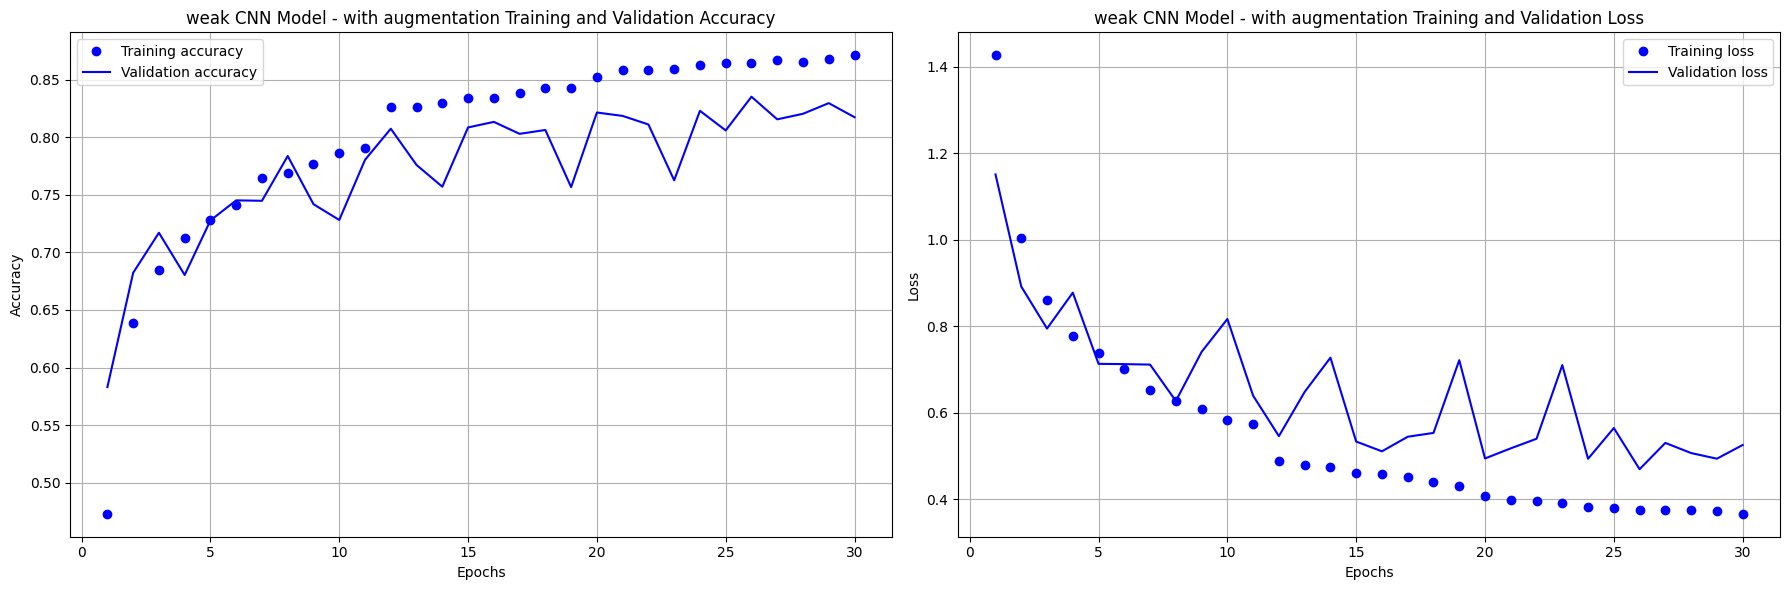

In [ ]:
plot_training_history(cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies, model_name="weak CNN Model - with augmentation")

# Celkové shrnutí.
V rámci tohoto notebooku byly vyzokušeny různé přístupy k řešení klasifikace na datasetu EuroSAT. Nejlepší modely byly modely konvoluční sítě a Vision transformeru. CNN model měl 1,130,378 parametrů. ViT by měl mít zhruba 86,8 milionu parametrů (86 567 000 + 199 434). Oba dva tyto modely dosahovali přesnosti 96 % na testovací množině. Kromě zmíněných modelů, byly také vyzkoušeny 3 MLP modely. První s malou architekturou dosahoval přesnosti okolo 40 - 45 %, s robustnější architekturou bylo možné dosáhnout přesnosti necelých 70 %. Na posledním MLP modelu byl testován vliv randomSearch, u kterého se ukázalo, že zvyšoval přesnost v průměru o 5 %.
Nakonec bylo vyzkoušeno obohacování dat na (záměrně) slabším CNN modelu. Zde se podařilo overfitting modelu vyřešit za cenu snížení přesnosti modelu z cca 90 % na cca 85 %.
